In [1]:
!pip install split-folders
!pip install torch-summary

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Import essential libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy # A module that provides functions for creating copies of objects, useful for avoiding unintended modifications to variables.
import os # A module that provides a way to interact with the operating system, allowing for tasks such as file and directory manipulation.
import torch
from PIL import Image # A module from the Python Imaging Library (PIL) that provides functionality for opening, manipulating, and saving various image file formats.
from torch.utils.data import Dataset # A PyTorch class that represents a dataset and provides an interface for accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module from the torchvision library that provides common image transformations, such as resizing, cropping, and normalization.
from torch.utils.data import random_split # A function from PyTorch that allows for randomly splitting a dataset into training and validation subsets.
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn # A module in PyTorch that provides classes for defining and building neural networks.
from torchvision import utils # A module from torchvision that contains utility functions for working with images, such as saving and visualizing them.
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
import itertools # This import statement imports the itertools module, which provides functions for efficient looping and combining of iterables. It can be used for tasks such as generating combinations or permutations of elements.
from tqdm.notebook import trange, tqdm # These functions allow for the creation of progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
import time

warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brian-tumor-dataset/metadata_rgb_only.csv
/kaggle/input/brian-tumor-dataset/metadata.csv
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (489).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (72).tif
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2411).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1065).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1014).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (385).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1822).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (2023).jpg
/kaggle/input/brian-tumor-dataset/Brain Tumor Data Se

In [3]:
torch.manual_seed(42)

labels_df = pd.read_csv('/kaggle/input/brian-tumor-dataset/metadata.csv')
print(labels_df.head().to_markdown())

|    |   Unnamed: 0 | image           | class   | format   | mode   | shape         |
|---:|-------------:|:----------------|:--------|:---------|:-------|:--------------|
|  0 |            0 | Cancer (1).jpg  | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  1 |            1 | Cancer (1).png  | tumor   | PNG      | L      | (300, 240)    |
|  2 |            2 | Cancer (1).tif  | tumor   | TIFF     | RGB    | (256, 256, 3) |
|  3 |            3 | Cancer (10).jpg | tumor   | JPEG     | RGB    | (512, 512, 3) |
|  4 |            4 | Cancer (10).tif | tumor   | TIFF     | RGB    | (256, 256, 3) |


In [4]:
os.listdir('/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set')

['Brain Tumor', 'Healthy']

In [5]:
labels_df.shape

(4600, 6)

In [6]:
# Dataset Path
data_dir = '/kaggle/input/brian-tumor-dataset/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = '/kaggle/working/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:31, 146.56 files/s]


In [7]:
# calculate the mean and std 
compute_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Match your model's expected input size
    transforms.ToTensor(),
])
# Path to training data after splitting
train_dir = pathlib.Path('/kaggle/working/brain/train')

# Create dataset and dataloader
train_dataset = ImageFolder(train_dir, transform=compute_transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=4)

def compute_mean_std(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_pixels = 0

    for images, _ in loader:
        # images shape: [batch, channels, height, width]
        batch, channels, h, w = images.shape
        pixels_per_batch = batch * h * w

        # Sum across batch and spatial dimensions
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_squares = torch.sum(images ** 2, dim=[0, 2, 3])

        mean += sum_
        std += sum_of_squares
        total_pixels += pixels_per_batch

    # Final calculations
    mean /= total_pixels
    std = torch.sqrt(std / total_pixels - mean ** 2)

    return mean, std

mean, std = compute_mean_std(train_loader)
print(f"Dataset Mean: {mean}\nDataset Std: {std}")

Dataset Mean: tensor([0.2450, 0.2452, 0.2453])
Dataset Std: tensor([0.2553, 0.2554, 0.2555])


In [8]:
# define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        # transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
        
        # we are doing this, to prevent recalculating lets hard code it
        # transforms.Normalize(mean = mean,std = std)
        transforms.Normalize(mean = [0.2450, 0.2452, 0.2453],std = [0.2553, 0.2554, 0.2555])

   ]
)

In [9]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform) 
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.245, 0.2452, 0.2453], std=[0.2553, 0.2554, 0.2555])
)

In [10]:
# Visualiztion some images from Train Set
# CLS_label = {
#     0 : 'Brain Tumor',
#     1 : 'Healthy'
# } 
# figure = plt.figure(figsize=(10, 10))
# cols, rows = 4, 4
# for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(train_set), size=(1,)).item()
#     img, label = train_set[sample_idx]
#     figure.add_subplot(rows, cols, i)
#     plt.title(CLS_label[label])
#     plt.axis("off")
#     img_np = img.numpy().transpose((1, 2, 0))
#     # Clip pixel values to [0, 1]
#     img_valid_range = np.clip(img_np, 0, 1)
#     plt.imshow(img_valid_range)
#     plt.suptitle('Brain Images', y=0.95)
# plt.show()

In [11]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)
print(len(train_loader.dataset))
print(len(val_loader.dataset))

3679
921


In [12]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        print(y)
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1])
Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

tensor([0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0])


In [13]:
#helper function 
def findConv2dOutShape(hin,win,conv):
    # get conv arguments
    kernel_size = conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)


    return int(hout),int(wout)
    
#helper function 
def findMaxPool2dOutShape(hin,win,pool):
    # get pool arguments
    kernel_size = pool.kernel_size
    stride=pool.stride
    padding=pool.padding
    dilation=pool.dilation

    hout=np.floor((hin+2*padding-dilation*(kernel_size-1)-1)/stride+1)
    wout=np.floor((win+2*padding-dilation*(kernel_size-1)-1)/stride+1)


    return int(hout),int(wout)

In [14]:
# defining model architecture
# slightly modified version of AlexNet to fit our image size: 256*256 for fair comparison
class AlexNet(nn.Module):
    def __init__(self, num_classes=1):  # Binary classification (brain tumor vs. healthy)
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),  # Input: (3, 256, 256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  #adding this layer because the input size differs from the original setting of AlexNet
        hin, win = 256, 256
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                hin, win = findConv2dOutShape(hin, win, layer)
                print(layer)
                print(hin, win)
            elif isinstance(layer, nn.MaxPool2d):
                print(layer)
                hin, win = findMaxPool2dOutShape(hin, win, layer)
                print(hin, win)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * hin * win, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        # x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
AlexNet_model = AlexNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
summary(AlexNet_model, input_size=(3, 256, 256),device=device.type)


Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
62 62
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
30 30
Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
30 30
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
14 14
Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14 14
Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14 14
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
14 14
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
6 6
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       34,944
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       614,656
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       34,944
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       614,656
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       885,120
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       1,327,488
|    └─ReLU: 2-10                        --
|    └─Conv2d: 2-11                      884,992
|    └─ReLU: 2-12                        --
|    └─MaxPool2d: 2-13                   --
├─Sequential: 1-2                        --
|    └─Dropout: 2-14                     --
|    └─Linear: 2-15                      37,752,832
|    └─ReLU: 2-16                        --
|    └─Dropout: 2-17                     --
|    └─Linear: 2-18                      16,781,312
|    └─ReLU: 2-19            

In [16]:
# slightly modified version of VGG Network to fit our image size: 256*256 for fair comparison, using VGG11 because limitation of time and resource
class VGG11(nn.Module):
    def __init__(self,num_classes = 1):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        hin, win = 256, 256
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                hin, win = findConv2dOutShape(hin, win, layer)
                print(layer)
                print(hin, win)
            elif isinstance(layer, nn.MaxPool2d):
                print(layer)
                hin, win = findMaxPool2dOutShape(hin, win, layer)
                print(hin, win)
                
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512*hin*win, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self,x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
        

In [17]:
VGG11_model = VGG11()
summary(VGG11_model, input_size=(3, 256, 256),device=device.type)


Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
256 256
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
128 128
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
128 128
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
64 64
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
64 64
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
64 64
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
32 32
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
32 32
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
32 32
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
16 16
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
16 16
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
16 16
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
8 8
Lay

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       73,856
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       295,168
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       590,080
|    └─ReLU: 2-10                        --
|    └─MaxPool2d: 2-11                   --
|    └─Conv2d: 2-12                      1,180,160
|    └─ReLU: 2-13                        --
|    └─Conv2d: 2-14                      2,359,808
|    └─ReLU: 2-15                        --
|    └─MaxPool2d: 2-16                   --
|    └─Conv2d: 2-17                      2,359,808
|    └─ReLU: 2-18                        --
|    └─Conv2d: 2-19                      2,359,808
|    └─ReLU: 2-20         

In [18]:
# slightly modified version of ResNet to fit our image size: 256*256 for fair comparison, using RESNet18 because limitation of time and resource

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:  # handle channel mismatch 
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=1):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.in_channels = 64
        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [19]:
ResNet_model = ResNet18()

summary(ResNet_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Sequential: 3-6              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-7                  36,864
|    |    └─BatchNorm2d: 3-8             128
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 36,864
|    |    └─BatchNorm2d: 3-11            128
|    |    └─Sequential: 3-12             --
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|  

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    |    └─Sequential: 3-6              --
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-7                  36,864
|    |    └─BatchNorm2d: 3-8             128
|    |    └─ReLU: 3-9                    --
|    |    └─Conv2d: 3-10                 36,864
|    |    └─BatchNorm2d: 3-11            128
|    |    └─Sequential: 3-12             --
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|  

In [20]:
# slightly modified version of MobileNet-v1 to fit our image size: 256*256 for fair comparison 
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, 
                     padding=1, groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True)
        )
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class MobileNetV1(nn.Module):
    def __init__(self, num_classes=1):
        super(MobileNetV1, self).__init__()
        
        # Initial convolution
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Depthwise separable convolutions (MobileNet-v1 architecture)
        self.features.extend([
            DepthwiseSeparableConv(32, 64, 1),
            DepthwiseSeparableConv(64, 128, 2),
            DepthwiseSeparableConv(128, 128, 1),
            DepthwiseSeparableConv(128, 256, 2),
            DepthwiseSeparableConv(256, 256, 1),
            DepthwiseSeparableConv(256, 512, 2),
            *[DepthwiseSeparableConv(512, 512, 1) for _ in range(5)],
            DepthwiseSeparableConv(512, 1024, 2),
            DepthwiseSeparableConv(1024, 1024, 1) # architecture says stride = 2 but the input size didn't change? 
        ])

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)  
        x = self.avgpool(x)   
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        

In [21]:
MobileNetV1_model = MobileNetV1()
summary(MobileNetV1_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
|    └─ReLU: 2-3                         --
|    └─DepthwiseSeparableConv: 2-4       --
|    |    └─Sequential: 3-1              352
|    |    └─Sequential: 3-2              2,176
|    └─DepthwiseSeparableConv: 2-5       --
|    |    └─Sequential: 3-3              704
|    |    └─Sequential: 3-4              8,448
|    └─DepthwiseSeparableConv: 2-6       --
|    |    └─Sequential: 3-5              1,408
|    |    └─Sequential: 3-6              16,640
|    └─DepthwiseSeparableConv: 2-7       --
|    |    └─Sequential: 3-7              1,408
|    |    └─Sequential: 3-8              33,280
|    └─DepthwiseSeparableConv: 2-8       --
|    |    └─Sequential: 3-9              2,816
|    |    └─Sequential: 3-10             66,048
|    └─DepthwiseSeparableConv: 2-9       --
|    |    └─Sequential: 3-11             

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       864
|    └─BatchNorm2d: 2-2                  64
|    └─ReLU: 2-3                         --
|    └─DepthwiseSeparableConv: 2-4       --
|    |    └─Sequential: 3-1              352
|    |    └─Sequential: 3-2              2,176
|    └─DepthwiseSeparableConv: 2-5       --
|    |    └─Sequential: 3-3              704
|    |    └─Sequential: 3-4              8,448
|    └─DepthwiseSeparableConv: 2-6       --
|    |    └─Sequential: 3-5              1,408
|    |    └─Sequential: 3-6              16,640
|    └─DepthwiseSeparableConv: 2-7       --
|    |    └─Sequential: 3-7              1,408
|    |    └─Sequential: 3-8              33,280
|    └─DepthwiseSeparableConv: 2-8       --
|    |    └─Sequential: 3-9              2,816
|    |    └─Sequential: 3-10             66,048
|    └─DepthwiseSeparableConv: 2-9       --
|    |    └─Sequential: 3-11             

In [22]:
# optimization and loss
# Again for fair comparison, I will use the same optimizer and learning rate so we can compare their behaviour given same hyperparamter

loss_module = nn.BCEWithLogitsLoss() # as we are not sigmoiding at the model instead we are using logit

# optimization for 4 different models 

opt1 = optim.Adam(AlexNet_model.parameters(), lr=1e-3, weight_decay=1e-4)
opt2 = optim.Adam(VGG11_model.parameters(), lr=1e-3, weight_decay=1e-4)
opt3 = optim.Adam(ResNet_model.parameters(), lr=1e-3, weight_decay=1e-4)
opt4 = optim.Adam(MobileNetV1_model.parameters(), lr=1e-3, weight_decay=1e-4)





In [23]:
# define training helper method

def train(model, optimizer, loss_module, num_of_epoch=100 ):
    model = model.to(device)
    
    metrics = {
        'train_time': [],
        'inference_time': [],
        'train_loss': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': [],
        'val_accuracy': [],
        'val_loss': []
    }
    best_model_weights = copy.deepcopy(model.state_dict()) 
    best_val_recall = 0.0
    for epoch in tqdm(range(num_of_epoch)):
        model.train()
        running_loss = 0.0
        start_time = time.perf_counter()
        for data_inputs, data_labels in train_loader:
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) 

            loss = loss_module(preds, data_labels.float())


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        metrics["train_loss"].append(running_loss / len(train_loader.dataset))
        metrics["train_time"].append(time.perf_counter()-start_time)

        
        start_time = time.perf_counter()
        #recording evaluation of each epoch
        model.eval()
        val_preds = []
        val_labels = []
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.float().to(device)
                outputs = model(inputs).squeeze()
                val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                running_val_loss += loss.item()
        val_preds_bin = (np.array(val_preds) > 0.5).astype(int)
        val_labels = np.array(val_labels)
        
        metrics["val_loss"].append(running_val_loss / len(val_loader.dataset))
        metrics["val_f1"].append(f1_score(val_labels,val_preds_bin))
        metrics["val_precision"].append(precision_score(val_labels,val_preds_bin))
        metrics["val_recall"].append(recall_score(val_labels,val_preds_bin))
        metrics["val_accuracy"].append(accuracy_score(val_labels,val_preds_bin))
        metrics["inference_time"].append(time.perf_counter()-start_time)
        
        current_recall = metrics["val_recall"][-1]
        if current_recall > best_val_recall:
            best_val_recall = current_recall
            best_model_weights = copy.deepcopy(model.state_dict())
            print(f"New best recall: {best_val_recall:.4f} at epoch {epoch}")
            
    model.load_state_dict(best_model_weights)

    return model, metrics
            

In [24]:
# training AlexNet
AlexNet_model, AlexNet_model_Metrics= train(AlexNet_model,opt1,loss_module,100)
#torch.save(AlexNet_model, "AlexNet_model.pt")
# print(AlexNet_model_Metrics)

  0%|          | 0/100 [00:00<?, ?it/s]

New best recall: 0.3995 at epoch 1
New best recall: 0.7057 at epoch 2
New best recall: 0.7177 at epoch 3
New best recall: 0.8134 at epoch 7
New best recall: 0.8708 at epoch 9
New best recall: 0.9187 at epoch 10
New best recall: 0.9330 at epoch 16
New best recall: 0.9450 at epoch 17
New best recall: 0.9761 at epoch 18
New best recall: 0.9833 at epoch 24
New best recall: 0.9904 at epoch 53


In [25]:
# training MobileNet-V1
MobileNetV1_model, MobileNetV1_model_Metrics = train(MobileNetV1_model,opt4,loss_module, 100)
#torch.save(MobileNetV1_model, "MobileNetV1_model.pt")


  0%|          | 0/100 [00:00<?, ?it/s]

New best recall: 0.6411 at epoch 0
New best recall: 0.8278 at epoch 1
New best recall: 0.8995 at epoch 2
New best recall: 0.9258 at epoch 3
New best recall: 0.9450 at epoch 5
New best recall: 0.9641 at epoch 6
New best recall: 0.9833 at epoch 10
New best recall: 0.9856 at epoch 24
New best recall: 0.9928 at epoch 29


In [26]:
# training ResNet-18
ResNet_model, ResNet_model_Metrics = train(ResNet_model,opt3,loss_module, 100)
#torch.save(ResNet_model, "ResNet_model.pt")


  0%|          | 0/100 [00:00<?, ?it/s]

New best recall: 0.8301 at epoch 0
New best recall: 0.9474 at epoch 1
New best recall: 0.9689 at epoch 5
New best recall: 0.9713 at epoch 15
New best recall: 0.9761 at epoch 16
New best recall: 0.9856 at epoch 17
New best recall: 0.9880 at epoch 26
New best recall: 0.9904 at epoch 65
New best recall: 0.9928 at epoch 78


In [27]:
# training VGG11
VGG11_model, VGG11_model_Metrics = train(VGG11_model,opt2,loss_module, 100)
#torch.save(VGG11_model, "VGG11_model.pt")


  0%|          | 0/100 [00:00<?, ?it/s]

New best recall: 0.8804 at epoch 3
New best recall: 0.8828 at epoch 10
New best recall: 0.9163 at epoch 12
New best recall: 0.9474 at epoch 13
New best recall: 0.9641 at epoch 19
New best recall: 0.9809 at epoch 26
New best recall: 0.9904 at epoch 27
New best recall: 0.9928 at epoch 55


AlexNet_25 f1:  0.9415807560137457
AlexNet_25 precision:  0.9032967032967033
AlexNet_25 recall:  0.9832535885167464
AlexNet_25 time of training:  251.94942096399984
AlexNet_25 average time of inference:  2.5827260126799865
AlexNet_25 model size: 58,285,441
AlexNet_50 f1:  0.9613130128956624
AlexNet_50 precision:  0.9425287356321839
AlexNet_50 recall:  0.9808612440191388
AlexNet_50 time of training:  503.8606191430007
AlexNet_50 average time of inference:  2.5624718522799776
AlexNet_50 model size: 58,285,441
AlexNet_75 f1:  0.9699879951980792
AlexNet_75 precision:  0.9734939759036144
AlexNet_75 recall:  0.9665071770334929
AlexNet_75 time of training:  756.9751161300009
AlexNet_75 average time of inference:  2.5525066790399795
AlexNet_75 model size: 58,285,441
AlexNet_100 f1:  0.9702734839476814
AlexNet_100 precision:  0.9645390070921985
AlexNet_100 recall:  0.9645390070921985
AlexNet_100 time of training:  1011.429913573001
AlexNet_100 average time of inference:  2.557008271869986
AlexN

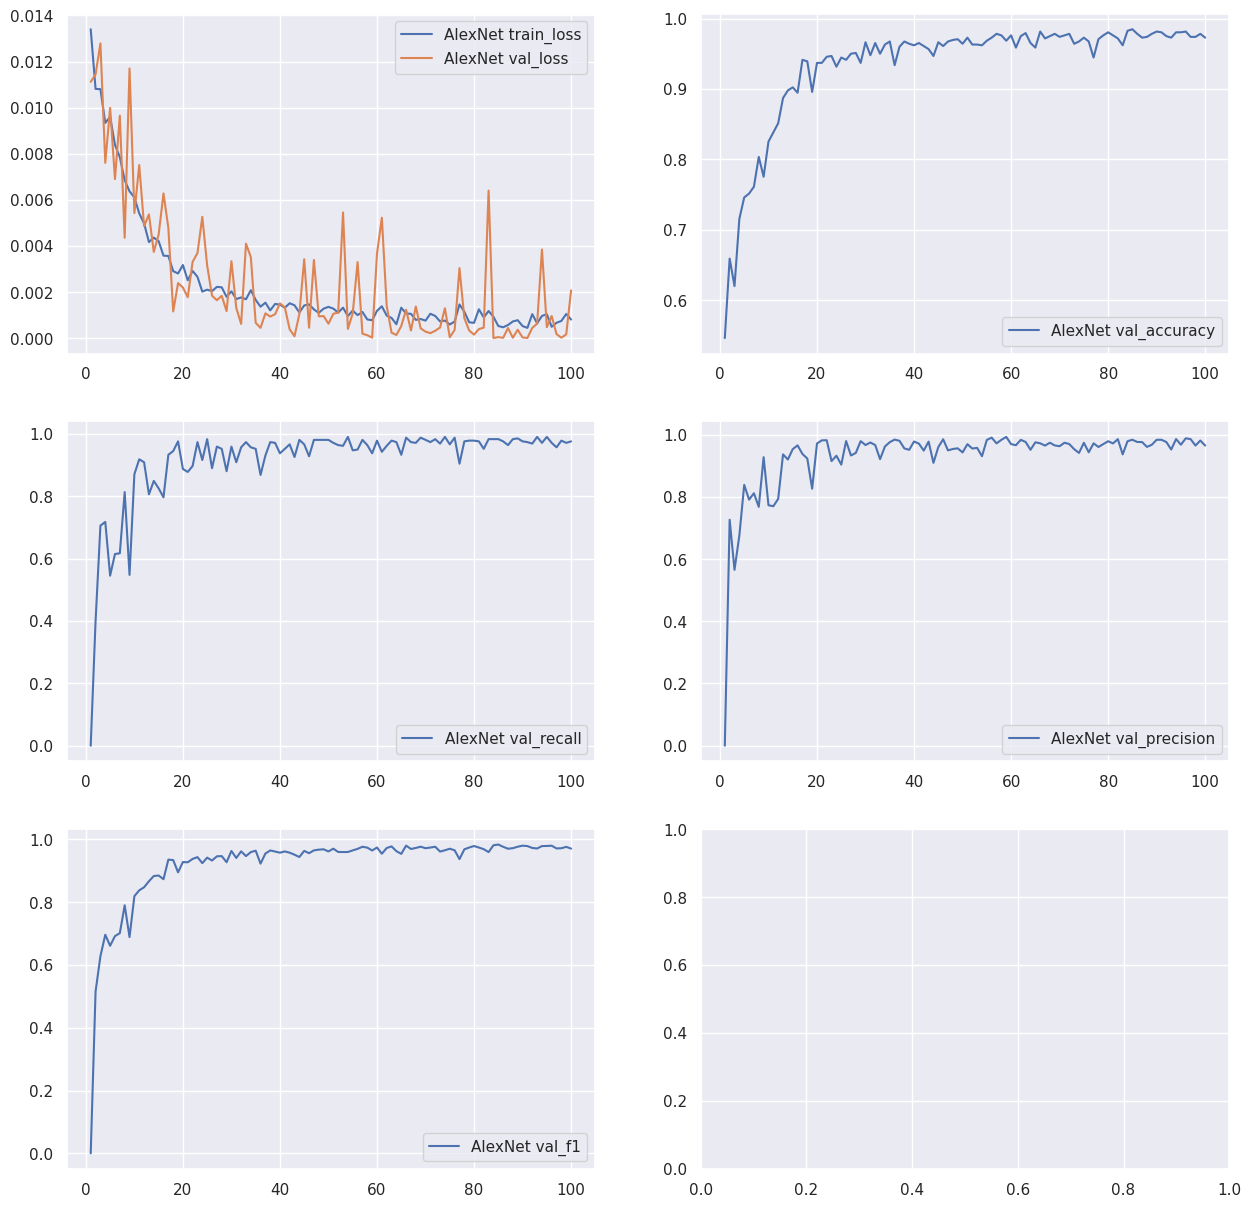

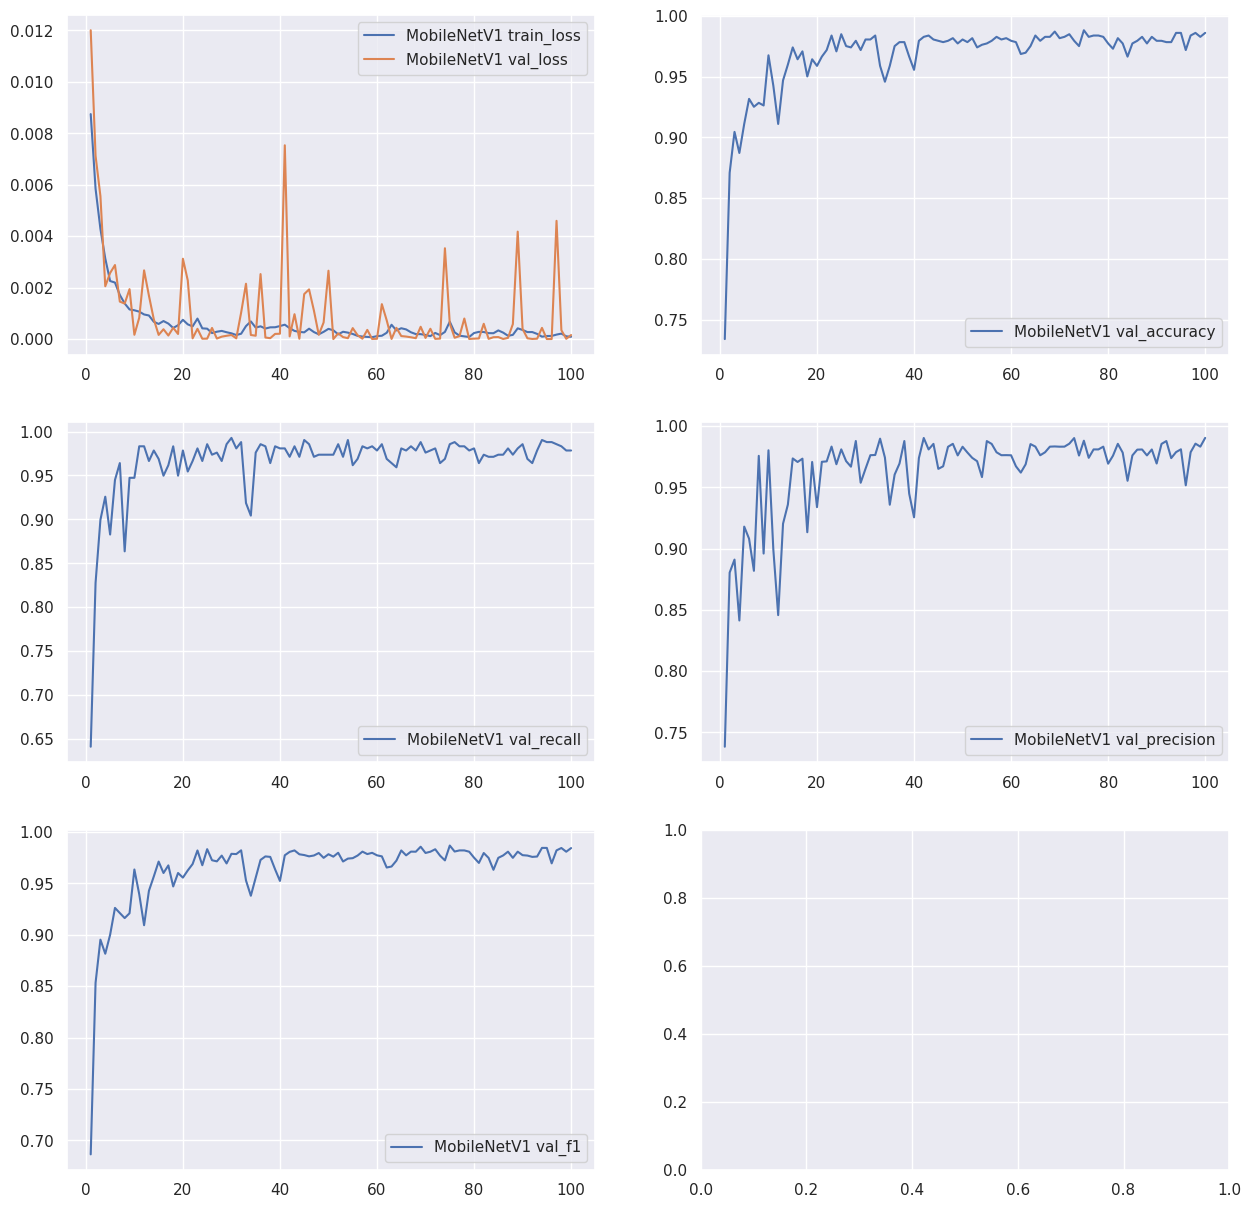

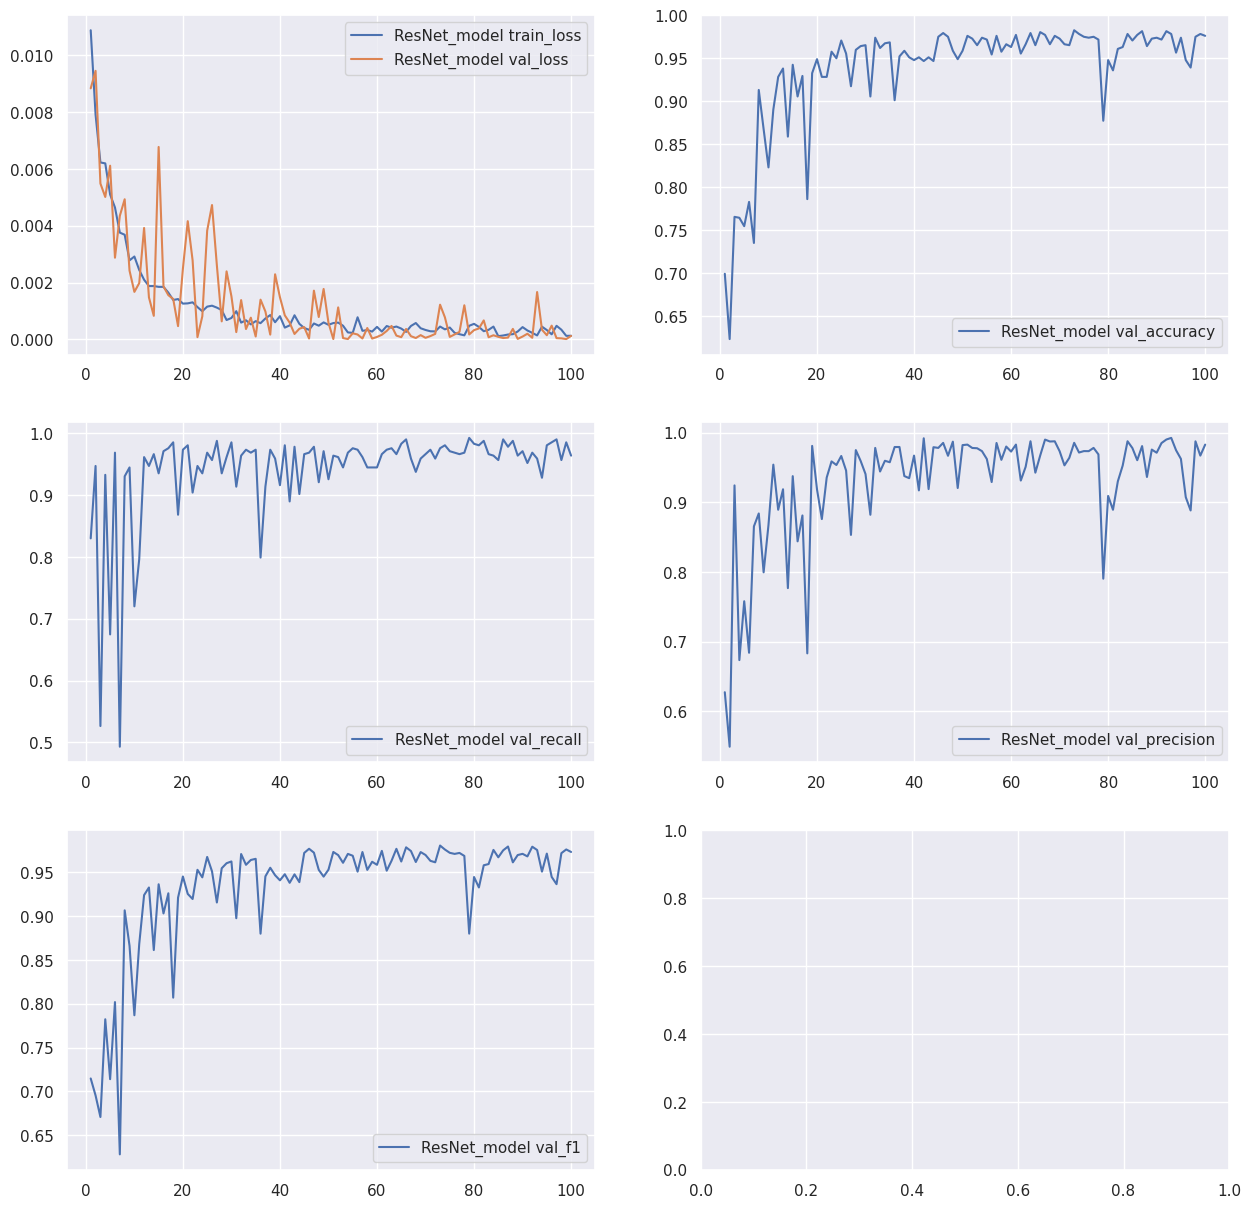

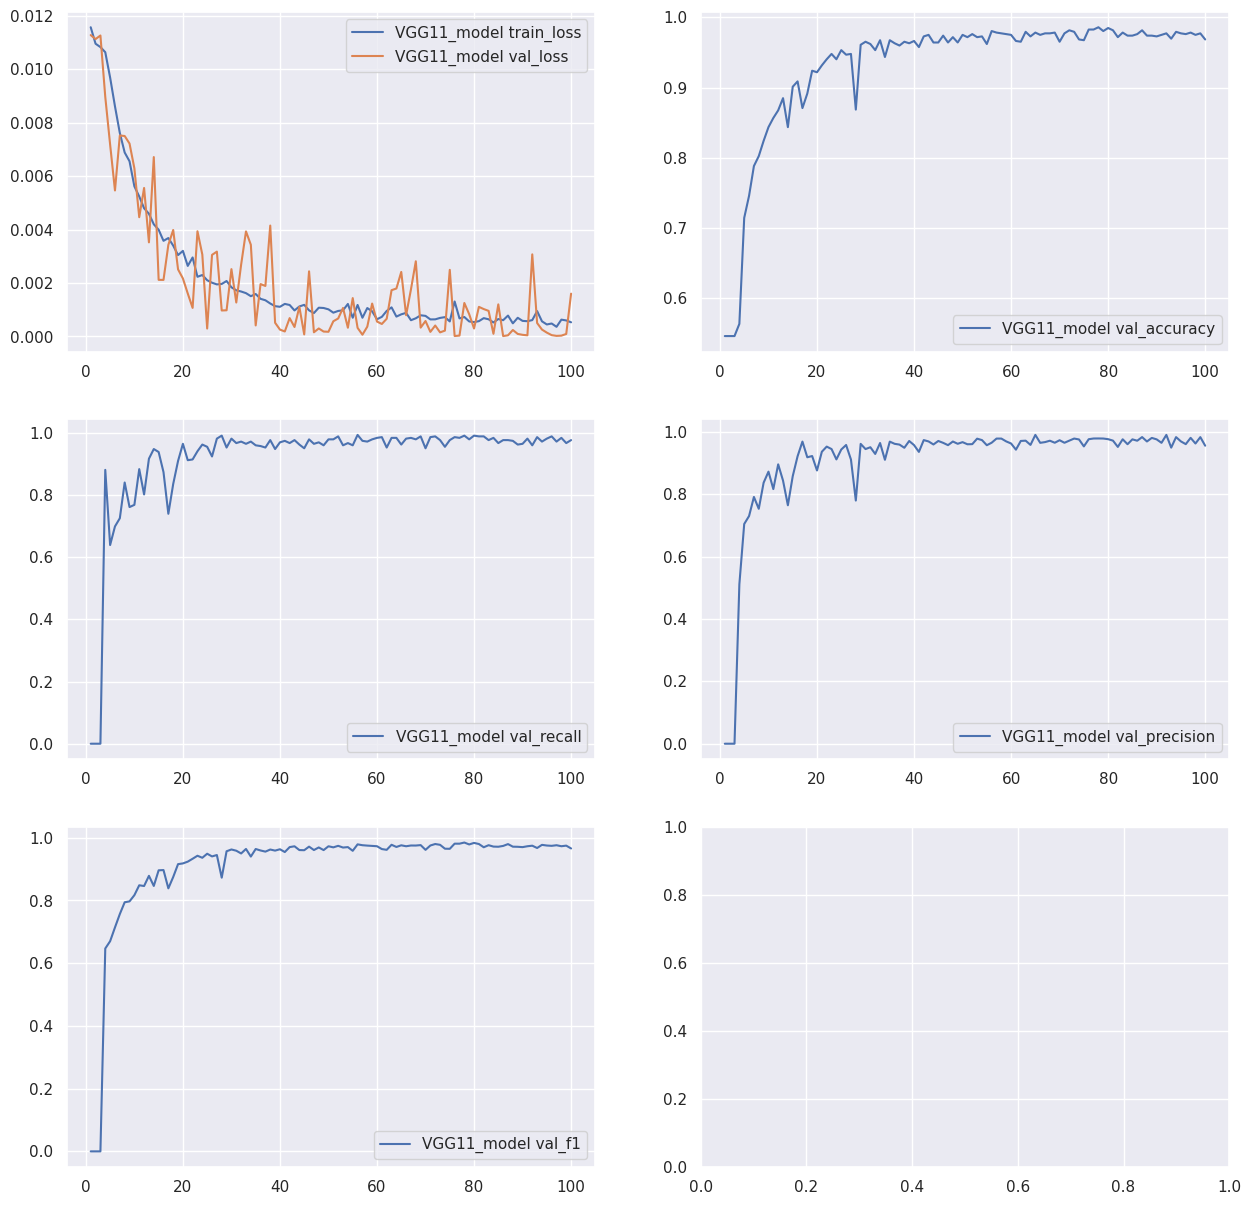

In [28]:
#evaluation and comparison after 100 epoch 

epochs=100
#separate graph for each architecture
fig,ax = plt.subplots(3,2,figsize=(15,15))
sns.lineplot(x=[*range(1,epochs+1)],y=AlexNet_model_Metrics["train_loss"],ax=ax[0][0],label='AlexNet train_loss')
sns.lineplot(x=[*range(1,epochs+1)],y=AlexNet_model_Metrics["val_loss"],ax=ax[0][0],label='AlexNet val_loss')
sns.lineplot(x=[*range(1,epochs+1)],y=AlexNet_model_Metrics["val_accuracy"],ax=ax[0][1],label='AlexNet val_accuracy')
sns.lineplot(x=[*range(1,epochs+1)],y=AlexNet_model_Metrics["val_recall"],ax=ax[1][0],label='AlexNet val_recall')
sns.lineplot(x=[*range(1,epochs+1)],y=AlexNet_model_Metrics["val_precision"],ax=ax[1][1],label='AlexNet val_precision')
sns.lineplot(x=[*range(1,epochs+1)],y=AlexNet_model_Metrics["val_f1"],ax=ax[2][0],label='AlexNet val_f1')

fig,ax = plt.subplots(3,2,figsize=(15,15))
sns.lineplot(x=[*range(1,epochs+1)],y=MobileNetV1_model_Metrics["train_loss"],ax=ax[0][0],label='MobileNetV1 train_loss')
sns.lineplot(x=[*range(1,epochs+1)],y=MobileNetV1_model_Metrics["val_loss"],ax=ax[0][0],label='MobileNetV1 val_loss')
sns.lineplot(x=[*range(1,epochs+1)],y=MobileNetV1_model_Metrics["val_accuracy"],ax=ax[0][1],label='MobileNetV1 val_accuracy')
sns.lineplot(x=[*range(1,epochs+1)],y=MobileNetV1_model_Metrics["val_recall"],ax=ax[1][0],label='MobileNetV1 val_recall')
sns.lineplot(x=[*range(1,epochs+1)],y=MobileNetV1_model_Metrics["val_precision"],ax=ax[1][1],label='MobileNetV1 val_precision')
sns.lineplot(x=[*range(1,epochs+1)],y=MobileNetV1_model_Metrics["val_f1"],ax=ax[2][0],label='MobileNetV1 val_f1')

fig,ax = plt.subplots(3,2,figsize=(15,15))
sns.lineplot(x=[*range(1,epochs+1)],y=ResNet_model_Metrics["train_loss"],ax=ax[0][0],label='ResNet_model train_loss')
sns.lineplot(x=[*range(1,epochs+1)],y=ResNet_model_Metrics["val_loss"],ax=ax[0][0],label='ResNet_model val_loss')
sns.lineplot(x=[*range(1,epochs+1)],y=ResNet_model_Metrics["val_accuracy"],ax=ax[0][1],label='ResNet_model val_accuracy')
sns.lineplot(x=[*range(1,epochs+1)],y=ResNet_model_Metrics["val_recall"],ax=ax[1][0],label='ResNet_model val_recall')
sns.lineplot(x=[*range(1,epochs+1)],y=ResNet_model_Metrics["val_precision"],ax=ax[1][1],label='ResNet_model val_precision')
sns.lineplot(x=[*range(1,epochs+1)],y=ResNet_model_Metrics["val_f1"],ax=ax[2][0],label='ResNet_model val_f1')

fig,ax = plt.subplots(3,2,figsize=(15,15))
sns.lineplot(x=[*range(1,epochs+1)],y=VGG11_model_Metrics["train_loss"],ax=ax[0][0],label='VGG11_model train_loss')
sns.lineplot(x=[*range(1,epochs+1)],y=VGG11_model_Metrics["val_loss"],ax=ax[0][0],label='VGG11_model val_loss')
sns.lineplot(x=[*range(1,epochs+1)],y=VGG11_model_Metrics["val_accuracy"],ax=ax[0][1],label='VGG11_model val_accuracy')
sns.lineplot(x=[*range(1,epochs+1)],y=VGG11_model_Metrics["val_recall"],ax=ax[1][0],label='VGG11_model val_recall')
sns.lineplot(x=[*range(1,epochs+1)],y=VGG11_model_Metrics["val_precision"],ax=ax[1][1],label='VGG11_model val_precision')
sns.lineplot(x=[*range(1,epochs+1)],y=VGG11_model_Metrics["val_f1"],ax=ax[2][0],label='VGG11_model val_f1')




# data for table for 4 architectures in epoch 25, 50, 75, 100
print("===================================================")
print("AlexNet_25 f1: ", AlexNet_model_Metrics["val_f1"][24])
print("AlexNet_25 precision: ", AlexNet_model_Metrics["val_precision"][24])
print("AlexNet_25 recall: ", AlexNet_model_Metrics["val_recall"][24] )
print("AlexNet_25 time of training: ", sum(AlexNet_model_Metrics["train_time"][:25]))
print("AlexNet_25 average time of inference: ", sum(AlexNet_model_Metrics["inference_time"][:25])/25)
print("AlexNet_25 model size: 58,285,441" )
print("===================================================")
print("AlexNet_50 f1: ", AlexNet_model_Metrics["val_f1"][49] )
print("AlexNet_50 precision: ", AlexNet_model_Metrics["val_precision"][49])
print("AlexNet_50 recall: ", AlexNet_model_Metrics["val_recall"][49])
print("AlexNet_50 time of training: ", sum(AlexNet_model_Metrics["train_time"][:50]) )
print("AlexNet_50 average time of inference: ", sum(AlexNet_model_Metrics["inference_time"][:50])/50)
print("AlexNet_50 model size: 58,285,441" )
print("===================================================")
print("AlexNet_75 f1: ", AlexNet_model_Metrics["val_f1"][74])
print("AlexNet_75 precision: ", AlexNet_model_Metrics["val_precision"][74])
print("AlexNet_75 recall: ", AlexNet_model_Metrics["val_recall"][74] )
print("AlexNet_75 time of training: ", sum(AlexNet_model_Metrics["train_time"][:75]) )
print("AlexNet_75 average time of inference: ", sum(AlexNet_model_Metrics["inference_time"][:75])/75)
print("AlexNet_75 model size: 58,285,441" )
print("===================================================")
print("AlexNet_100 f1: ", AlexNet_model_Metrics["val_f1"][99] )
print("AlexNet_100 precision: ", AlexNet_model_Metrics["val_precision"][99] )
print("AlexNet_100 recall: ", AlexNet_model_Metrics["val_precision"][99] )
print("AlexNet_100 time of training: ",sum(AlexNet_model_Metrics["train_time"][:100]) )
print("AlexNet_100 average time of inference: ", sum(AlexNet_model_Metrics["inference_time"][:100])/100)
print("AlexNet_100 model size: 58,285,441" )


print("===================================================")
print("MobileNetV1_25 f1: ", MobileNetV1_model_Metrics["val_f1"][24])
print("MobileNetV1_25 precision: ", MobileNetV1_model_Metrics["val_precision"][24])
print("MobileNetV1_25 recall: ", MobileNetV1_model_Metrics["val_recall"][24] )
print("MobileNetV1_25 time of training: ", sum(MobileNetV1_model_Metrics["train_time"][:25]))
print("MobileNetV1_25 average time of inference: ", sum(MobileNetV1_model_Metrics["inference_time"][:25])/25)
print("MobileNetV1_25 model size: 3,208,001" )
print("===================================================")
print("MobileNetV1_50 f1: ", MobileNetV1_model_Metrics["val_f1"][49] )
print("MobileNetV1_50 precision: ", MobileNetV1_model_Metrics["val_precision"][49])
print("MobileNetV1_50 recall: ", MobileNetV1_model_Metrics["val_recall"][49])
print("MobileNetV1_50 time of training: ", sum(MobileNetV1_model_Metrics["train_time"][:50]) )
print("MobileNetV1_50 average time of inference: ", sum(MobileNetV1_model_Metrics["inference_time"][:50])/50)
print("MobileNetV1_50 model size: 3,208,001" )
print("===================================================")
print("MobileNetV1_75 f1: ", MobileNetV1_model_Metrics["val_f1"][74])
print("MobileNetV1_75 precision: ", MobileNetV1_model_Metrics["val_precision"][74])
print("MobileNetV1_75 recall: ", MobileNetV1_model_Metrics["val_recall"][74] )
print("MobileNetV1_75 time of training: ", sum(MobileNetV1_model_Metrics["train_time"][:75]) )
print("MobileNetV1_75 average time of inference: ", sum(MobileNetV1_model_Metrics["inference_time"][:75])/75)
print("MobileNetV1_75 model size: 3,208,001" )
print("===================================================")
print("MobileNetV1_100 f1: ", MobileNetV1_model_Metrics["val_f1"][99] )
print("MobileNetV1_100 precision: ", MobileNetV1_model_Metrics["val_precision"][99] )
print("MobileNetV1_100 recall: ", MobileNetV1_model_Metrics["val_precision"][99] )
print("MobileNetV1_100 time of training: ",sum(MobileNetV1_model_Metrics["train_time"][:100]) )
print("MobileNetV1_100 average time of inference: ", sum(MobileNetV1_model_Metrics["inference_time"][:100])/100)
print("MobileNetV1_100 model size: 3,208,001" )


print("===================================================")
print("ResNet_18_25 f1: ", ResNet_model_Metrics["val_f1"][24])
print("ResNet_18_25 precision: ", ResNet_model_Metrics["val_precision"][24])
print("ResNet_18_25 recall: ", ResNet_model_Metrics["val_recall"][24] )
print("ResNet_18_25 time of training: ", sum(ResNet_model_Metrics["train_time"][:25]))
print("ResNet_18_25 average time of inference: ", sum(ResNet_model_Metrics["inference_time"][:25])/25)
print("ResNet_18_25 model size: 11,177,025" )
print("===================================================")
print("ResNet_18_50 f1: ", ResNet_model_Metrics["val_f1"][49] )
print("ResNet_18_50 precision: ", ResNet_model_Metrics["val_precision"][49])
print("ResNet_18_50 recall: ", ResNet_model_Metrics["val_recall"][49])
print("ResNet_18_50 time of training: ", sum(ResNet_model_Metrics["train_time"][:50]) )
print("ResNet_18_50 average time of inference: ", sum(ResNet_model_Metrics["inference_time"][:50])/50)
print("ResNet_18_50 model size: 11,177,025" )
print("===================================================")
print("ResNet_18_75 f1: ", ResNet_model_Metrics["val_f1"][74])
print("ResNet_18_75 precision: ", ResNet_model_Metrics["val_precision"][74])
print("ResNet_18_75 recall: ", ResNet_model_Metrics["val_recall"][74] )
print("ResNet_18_75 time of training: ", sum(ResNet_model_Metrics["train_time"][:75]) )
print("ResNet_18_75 average time of inference: ", sum(ResNet_model_Metrics["inference_time"][:75])/75)
print("ResNet_18_75 model size: 11,177,025" )
print("===================================================")
print("ResNet_18_100 f1: ", ResNet_model_Metrics["val_f1"][99] )
print("ResNet_18_100 precision: ", ResNet_model_Metrics["val_precision"][99] )
print("ResNet_18_100 recall: ", ResNet_model_Metrics["val_precision"][99] )
print("ResNet_18_100 time of training: ",sum(ResNet_model_Metrics["train_time"][:100]) )
print("ResNet_18_100 average time of inference: ", sum(ResNet_model_Metrics["inference_time"][:100])/100)
print("ResNet_18_100 model size: 11,177,025" )


print("===================================================")
print("VGG11_model_25 f1: ", VGG11_model_Metrics["val_f1"][24])
print("VGG11_model_25 precision: ", VGG11_model_Metrics["val_precision"][24])
print("VGG11_model_25 recall: ", VGG11_model_Metrics["val_recall"][24] )
print("VGG11_model_25 time of training: ", sum(VGG11_model_Metrics["train_time"][:25]))
print("VGG11_model_25 average time of inference: ", sum(VGG11_model_Metrics["inference_time"][:25])/25)
print("VGG11_model_25 model size: 160,227,713" )
print("===================================================")
print("VGG11_model_50 f1: ", VGG11_model_Metrics["val_f1"][49] )
print("VGG11_model_50 precision: ", VGG11_model_Metrics["val_precision"][49])
print("VGG11_model_50 recall: ", VGG11_model_Metrics["val_recall"][49])
print("VGG11_model_50 time of training: ", sum(VGG11_model_Metrics["train_time"][:50]) )
print("VGG11_model_50 average time of inference: ", sum(VGG11_model_Metrics["inference_time"][:50])/50)
print("VGG11_model_50 model size: 160,227,713" )
print("===================================================")
print("VGG11_model_75 f1: ", VGG11_model_Metrics["val_f1"][74])
print("VGG11_model_75 precision: ", VGG11_model_Metrics["val_precision"][74])
print("VGG11_model_75 recall: ", VGG11_model_Metrics["val_recall"][74] )
print("VGG11_model_75 time of training: ", sum(VGG11_model_Metrics["train_time"][:75]) )
print("VGG11_model_75 average time of inference: ", sum(VGG11_model_Metrics["inference_time"][:75])/75)
print("VGG11_model_75 model size: 160,227,713" )
print("===================================================")
print("VGG11_model_100 f1: ", VGG11_model_Metrics["val_f1"][99] )
print("VGG11_model_100 precision: ", VGG11_model_Metrics["val_precision"][99] )
print("VGG11_model_100 recall: ", VGG11_model_Metrics["val_precision"][99] )
print("VGG11_model_100 time of training: ",sum(VGG11_model_Metrics["train_time"][:100]) )
print("VGG11_model_100 average time of inference: ", sum(VGG11_model_Metrics["inference_time"][:100])/100)
print("VGG11_model_100 model size: 160,227,713" )

In [31]:
# eval helper method
def eval(model):
    start_time = time.perf_counter()
    val_preds=[]
    val_labels=[]
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.float().to(device)
            outputs = model(inputs).squeeze()
            val_preds.extend(torch.sigmoid(outputs).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
        val_preds_bin = (np.array(val_preds) > 0.5).astype(int)
        val_labels = np.array(val_labels)

        

        print(" f1: ", f1_score(val_labels,val_preds_bin))
        print(" precision: ", precision_score(val_labels,val_preds_bin))
        print(" recall: ", recall_score(val_labels,val_preds_bin) )
        print(" accuracy: ", accuracy_score(val_labels,val_preds_bin))
        print(" average time of inference: ", time.perf_counter()-start_time)
        
        


In [32]:
# best recall model evaluation
print("===================================================")
print("AlexNet")
eval(AlexNet_model)
print("===================================================")
print("MobileNet-v1")
eval(MobileNetV1_model)

print("===================================================")
print("ResNet-18")
eval(ResNet_model)

print("===================================================")
print("VGG-11")
eval(VGG11_model)


AlexNet
 f1:  0.9614035087719297
 precision:  0.9405034324942791
 recall:  0.9832535885167464
 accuracy:  0.9641693811074918
 average time of inference:  2.8055154970006697
MobileNet-v1
 f1:  0.9753231492361927
 precision:  0.9584295612009238
 recall:  0.992822966507177
 accuracy:  0.9771986970684039
 average time of inference:  2.700319795998439
ResNet-18
 f1:  0.876451953537487
 precision:  0.7844990548204159
 recall:  0.992822966507177
 accuracy:  0.8729641693811075
 average time of inference:  2.722827936999238
VGG-11
 f1:  0.9716312056737588
 precision:  0.9602803738317757
 recall:  0.9832535885167464
 accuracy:  0.9739413680781759
 average time of inference:  3.564981727000486
